In [74]:
import torch 
from stimulus import *
from BIRNN import *
import matplotlib.pyplot as plt 

memory_size = 128
in_emb = memory_size//4
mem_lay = 1
inputs_dim = 2
decisions = 3

sensor = ResMLP(inputs_dim, in_emb, [64,64,64])
actor = ResMLP(memory_size, decisions, [64,64,64])

model = SenseMemAct(sensor, actor, in_sz=in_emb, mem_sz=memory_size, mem_lay=mem_lay, decisions=decisions)

In [75]:
# load model
modelfname = './checkpoint.pth'
state = torch.load(modelfname, map_location=torch.device('cpu'))
model.load_state_dict(state)

<All keys matched successfully>

In [76]:
print(model.mem, model.sense, model.act, sep = '\n\n')

nBRC(
  (ff_ia): Linear(in_features=32, out_features=128, bias=False)
  (ff_ha): Linear(in_features=128, out_features=128, bias=False)
  (ff_ic): Linear(in_features=32, out_features=128, bias=False)
  (ff_hc): Linear(in_features=128, out_features=128, bias=False)
  (ff_io): Linear(in_features=32, out_features=128, bias=False)
)

ResMLP(
  (head): Linear(in_features=2, out_features=64, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (tail): Linear(in_features=64, out_features=32, bias=True)
  (activ): ReLU()
)

ResMLP(
  (head): Linear(in_features=128, out_features=64, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=64, bias=True)
  )
  (tail): Linear(in_features=64, out_features=3, bias=True)
  (activ): ReLU()
)


torch.Size([128, 128])


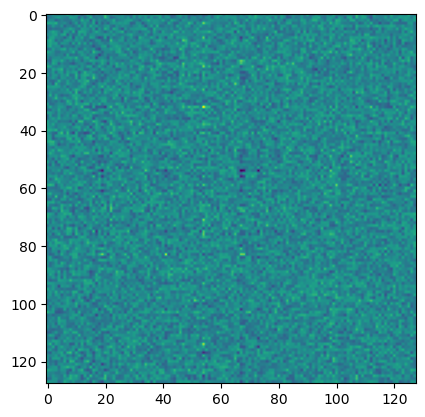

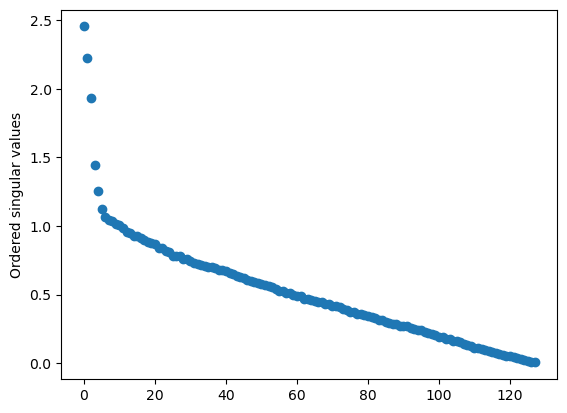

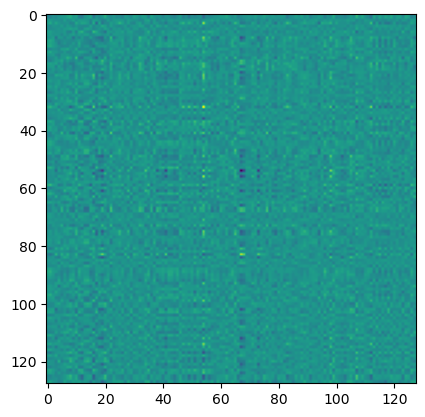

In [77]:
# weights of the linear layer that combines memory 'h' to produce bifurcation parameter 'a'
print(model.mem.ff_ha.weight.shape)
w_mat = model.mem.ff_ha.weight.detach()
plt.imshow(w_mat)
plt.show()

u,s,v = torch.linalg.svd(w_mat)
plt.scatter(torch.arange(len(s)), s)
plt.ylabel('Ordered singular values')
plt.show()

s[6:] = 0
plt.imshow(u@torch.diag(s)@v)

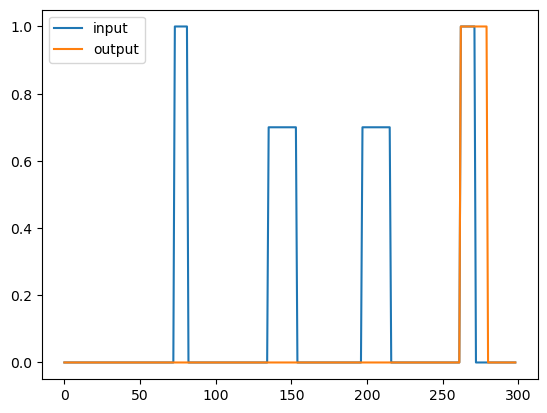

In [78]:
stimG = StimGenerator(dt=.1)
d_i, d_o = stimG.get_batch_data(1)
d_i, d_o = stimG.extend_sim(30, d_i, d_o)
# d_i, d_o = stimG.concat_sim(d_i, d_o)

plt.plot(d_i[0], label = 'input')
plt.plot(d_o[0], label = 'output')
plt.legend()
plt.show()

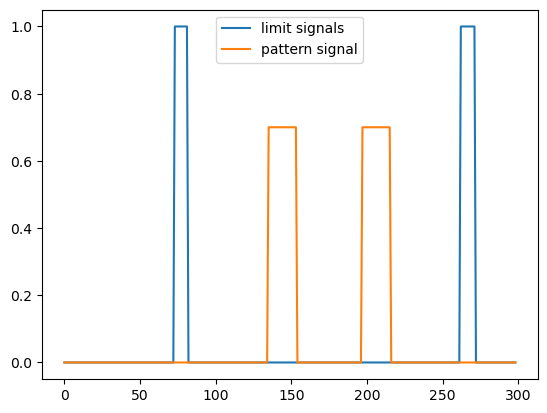

In [79]:
B, L = d_i.shape
mod_in = torch.zeros((B,L,2))
mod_in[...,0][d_i == 1] = 1
mod_in[...,1][d_i != 1] = d_i[d_i!=1]
plt.plot(mod_in[0,:,0], label = 'limit signals')
plt.plot(mod_in[0,:,1], label = 'pattern signal')
plt.legend()
plt.show()
# pred = model()

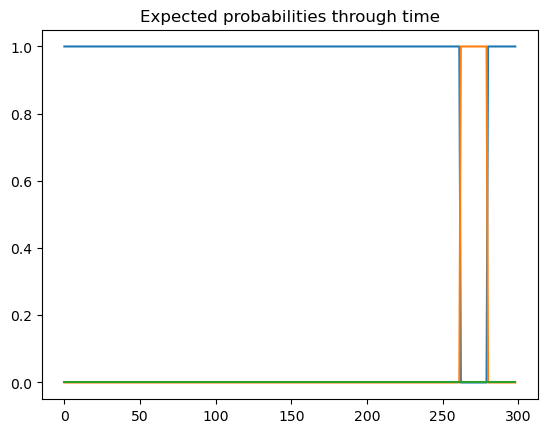

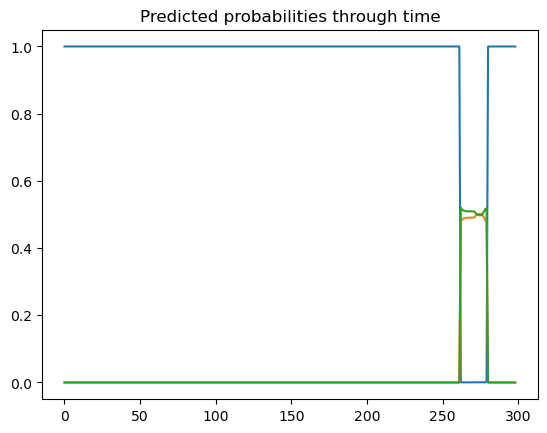

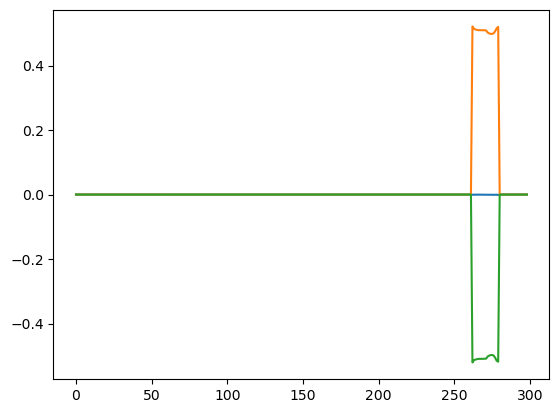

In [80]:
dc = decode_choice(d_o)
dc.shape
plt.plot(dc[0])
plt.title('Expected probabilities through time')
plt.show()

with torch.no_grad():
    pred_c = model(mod_in)
    plt.plot(pred_c[0])
    plt.title('Predicted probabilities through time') 
    plt.show()
    plt.plot(dc[0] - pred_c[0])
    plt.show()

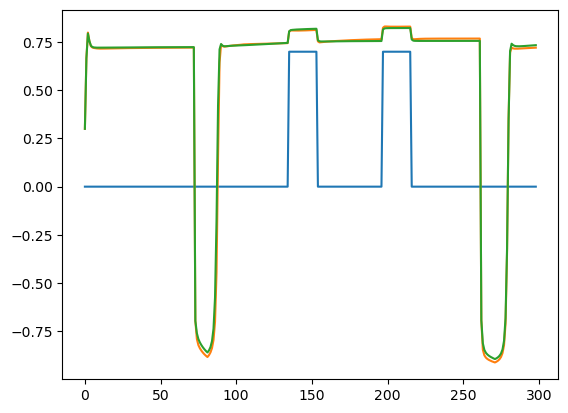

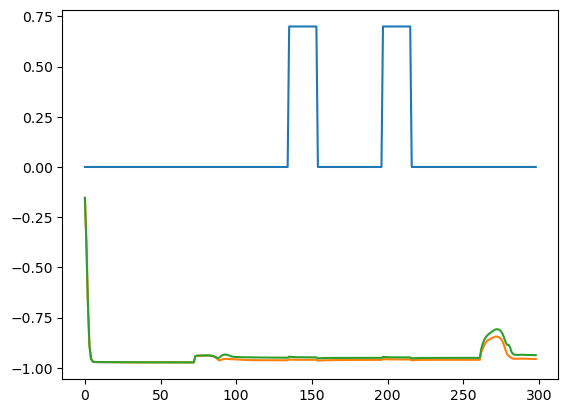

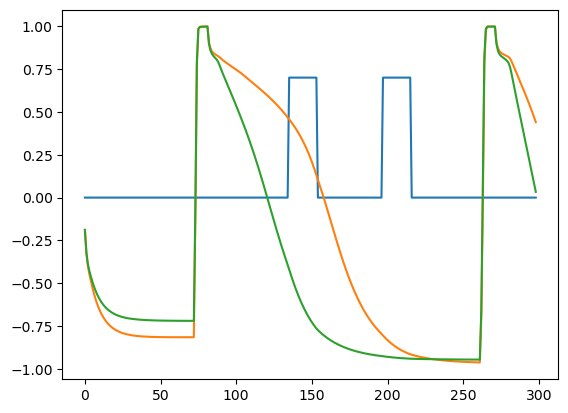

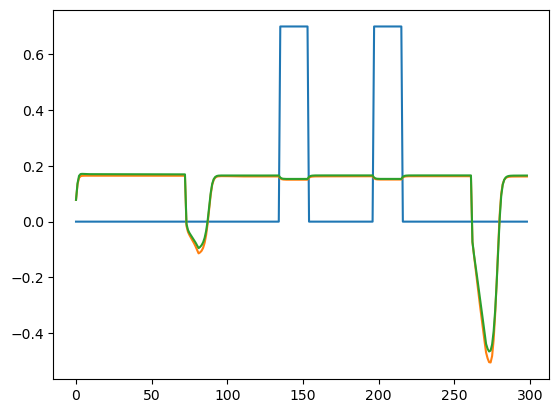

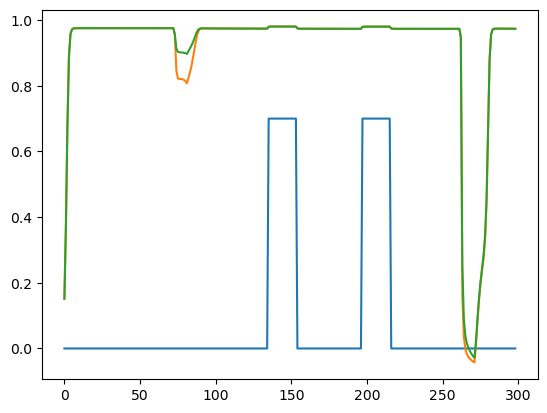

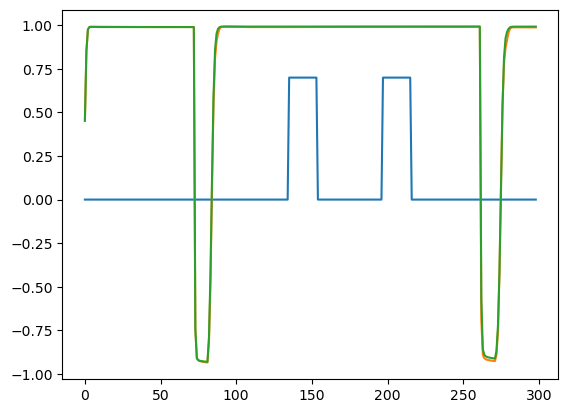

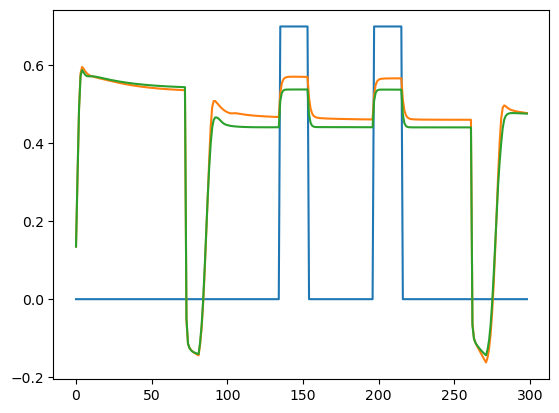

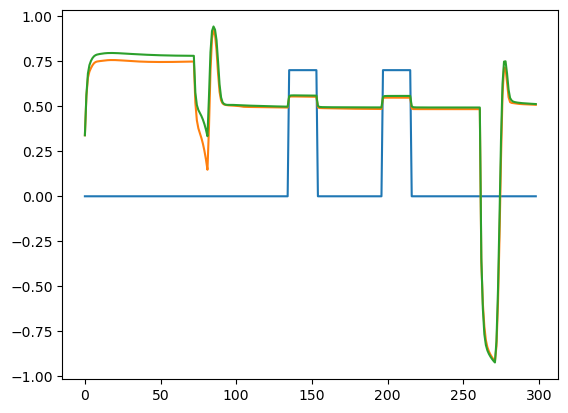

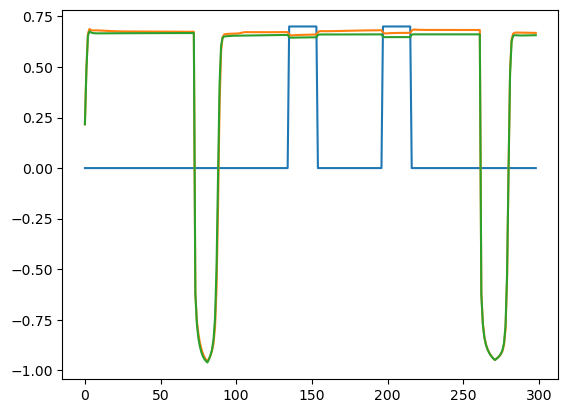

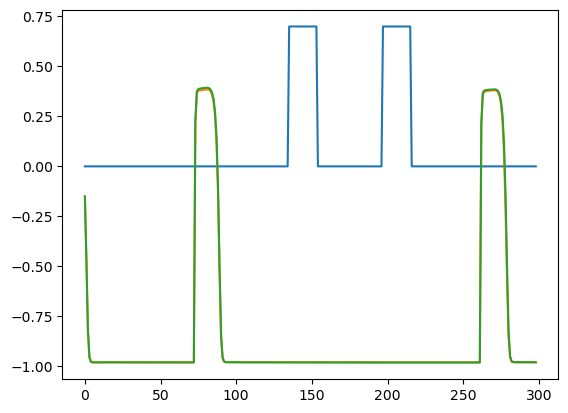

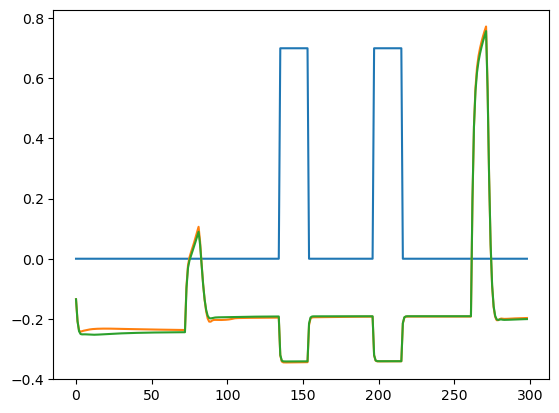

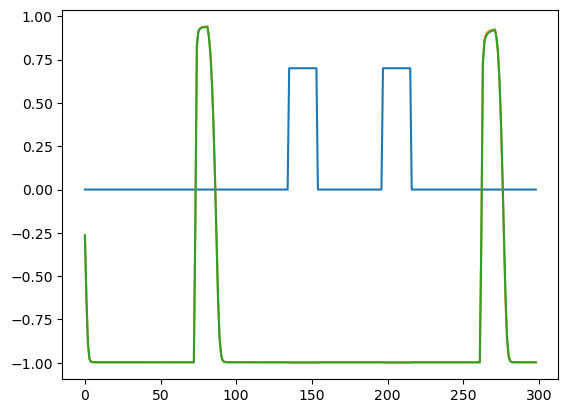

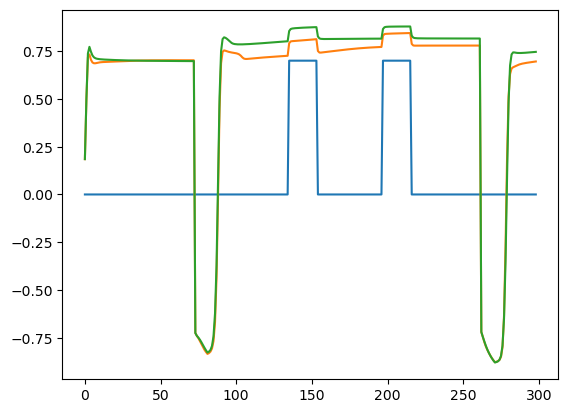

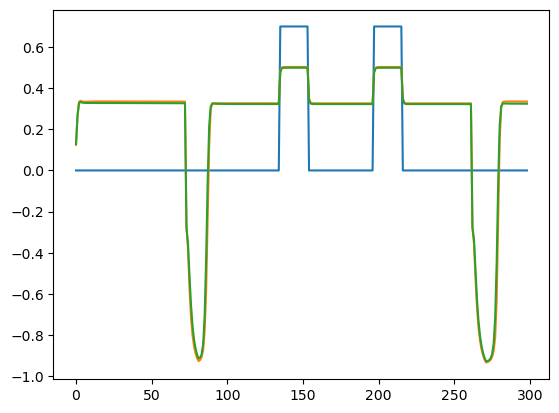

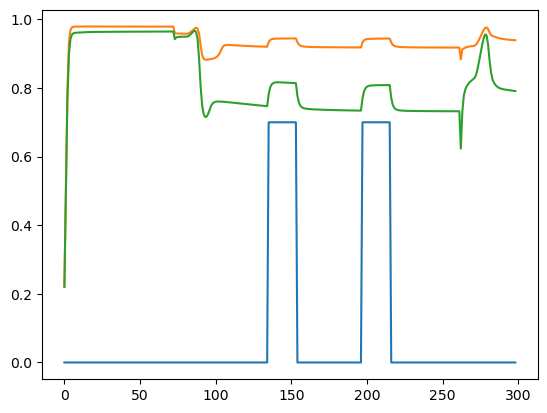

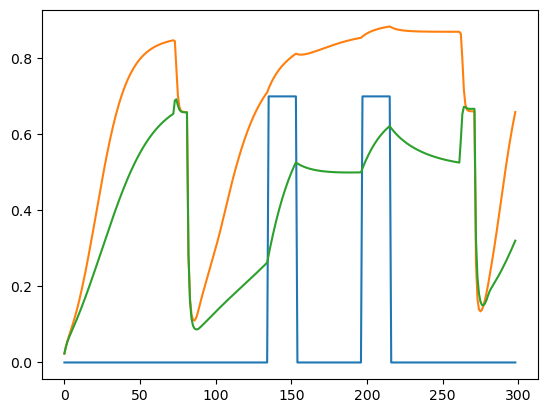

In [81]:
# dive into memory

with torch.no_grad():
    pred_c = model.forward(x=mod_in, debug_mem=True)
    model.mem.ff_ha.weight = torch.nn.Parameter(u@torch.diag(s)@v)
    pred_pc = model.forward(x=mod_in, debug_mem=True)

for i in range(0,128,8):
    plt.clf()
    plt.plot(mod_in[0,:,1])
    plt.plot(pred_c[0,:,i])
    plt.plot(pred_pc[0,:,i])
    plt.show()